## Tugas Akhir Mata Kuliah Pengenalan Pola
Risky Armansyah (09021282126055), Mahendra Dinata (09021282126066), Sultan Rafi (09021282126067)

Pada tugas ini, kami menggunakan dataset biaya asuransi rumah sakit yang perlu dibayar oleh pasien di US. Data ini kami dapatkan dari salah satu situs terkenal yaitu kaggle dengan judul dataset 'Medical Cost Personal Dataset'. Dengan data ini, kami hendak membuat model regresi untuk memprediksi biaya yang perlu dikeluarkan oleh pasien dengan metode Linear Regression.

In [1]:
!pip install outlier_utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from OUTLIERS import smirnov_grubbs as grubbs
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from yellowbrick.model_selection import LearningCurve 

In [3]:
cwd = os.getcwd()
filepath = os.path.join(cwd, 'Data', 'insurance.csv')

df = pd.read_csv(filepath)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Data Cleaning
Pada section ini, akan dilakukan beberapa test dan analisa untuk membersihkan data agar data dapat digunakan dengan baik.

In [4]:
print(df.isna().sum(), '\n')
print(df.info())
print('\n', df.shape)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

 (1338, 7)


In [5]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


berdasarkan informasi diatas, dapat dikatakan dataset sudah diolah dengan baik dengan tidak adanya null values. Akan tetapi, dataset masih memiliki 1 duplicated value yang dapat kita drop langsung. 

In [6]:
df = df.drop_duplicates()

In [7]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


Berdasarkan informasi diatas, kita dapat mengetahui bahwa rata-rata pada kolom age, bmi, dan children memiliki jumlah yang relatif sama. Akan tetapi, pada kolom charges dapat dilihat selisih antara rata-rata dan mediannya cukup tinggi, yang hal ini berarti terdapat beberapa outliers pada dataset ini.

Berikut pengecekan nilai outlier pada tiap kolom dataset.

<AxesSubplot:xlabel='children'>

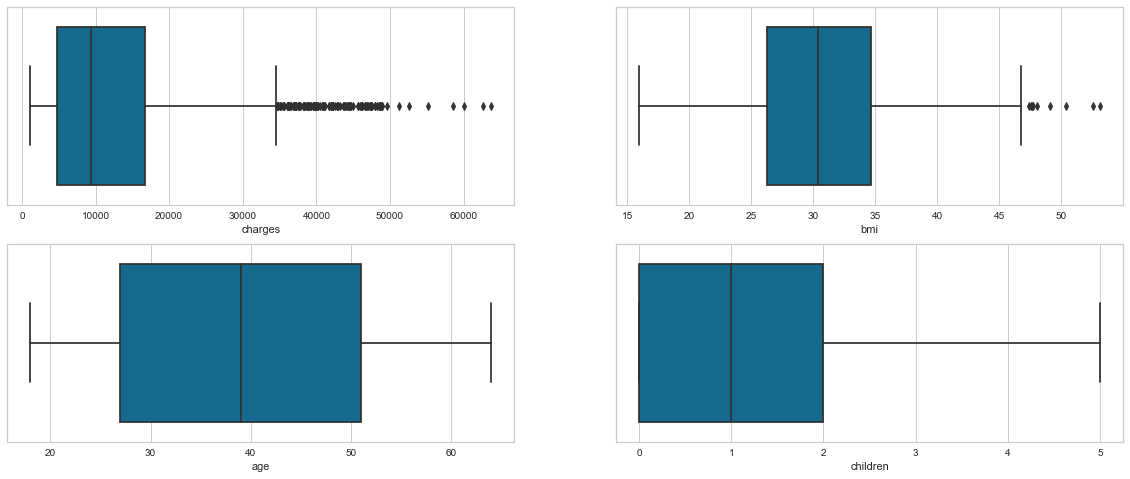

In [8]:
fig, (ax1,ax2) = plt.subplots(2,2, figsize=(20,8))

sns.boxplot(data = df, x = 'charges', ax=ax1[0])
sns.boxplot(data = df, x = 'bmi', ax=ax1[1])
sns.boxplot(data = df, x = 'age', ax=ax2[0])
sns.boxplot(data = df, x = 'children', ax=ax2[1])

Dari informasi di atas kita dapat memastikan bahwa kolom charges dan bmi memiliki outlier. 

Namun, kita perlu perhatikan juga apakah outliers tersebut benar-benar merupakan outliers yang mengganggu data (false value) atau outlier tersebut memang merupakan bagian dari dataset. Untuk mengatasi hal ini, kami menggunakan grubbs test untuk menghapus nilai yang mungkin menjadi 'real outlier' pada dataset.

Uji Grubbs adalah tes yang digunakan untuk mendeteksi outlier dalam kumpulan data univariat yang diasumsikan berasal dari populasi yang terdistribusi normal.

In [9]:
outlier_columns = ["bmi","charges"]
for col in outlier_columns:
    df[col] = grubbs.test(df[col],alpha=0.05)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1336 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 115.9+ KB


Setelah data diolah menggunakan grubbs test, terlihat pada kolom charges, 1 data dihapus yang merupakan 'real outlier' pada dataset ini. Kemudian, kami menggunakan mediannya untuk mengganti null value tersebut. 

In [11]:
df.charges.fillna(df['charges'].median(), inplace = True)

### Dataset Distribution Plot

Berikut distribusi data dari dataset yang kami gunakan.

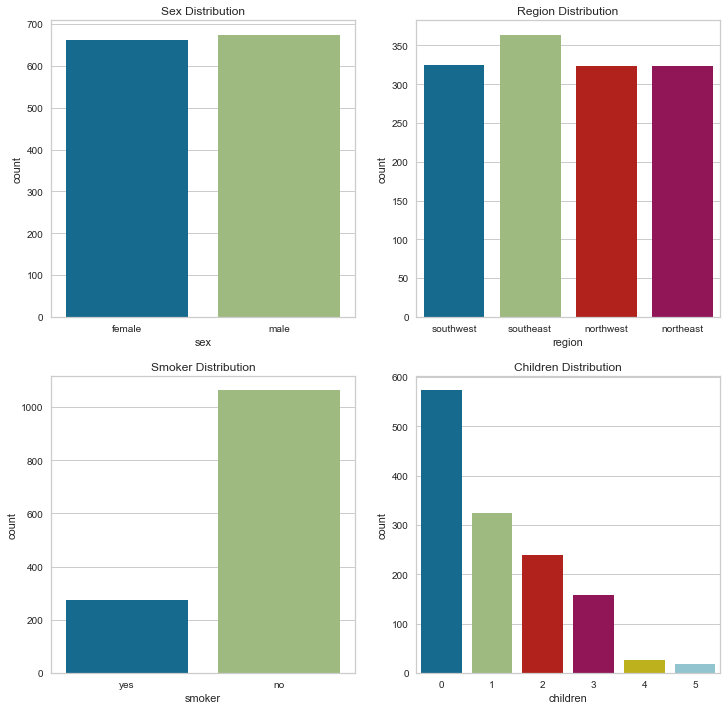

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))

sns.countplot(x='sex', data=df, ax = ax1)
ax1.title.set_text('Sex Distribution')

sns.countplot(x='region', data=df, ax = ax2)
ax2.title.set_text('Region Distribution')

sns.countplot(x='smoker', data=df, ax = ax3)
ax3.title.set_text('Smoker Distribution')

sns.countplot(x='children', data=df, ax = ax4)
ax4.title.set_text('Children Distribution')

Berdasarkan grafik, data pada kolom region dan sex memiliki persebaran yang rata. Sedangkan, pada kolom smoker dan children data tidak tersebar dengan rata.

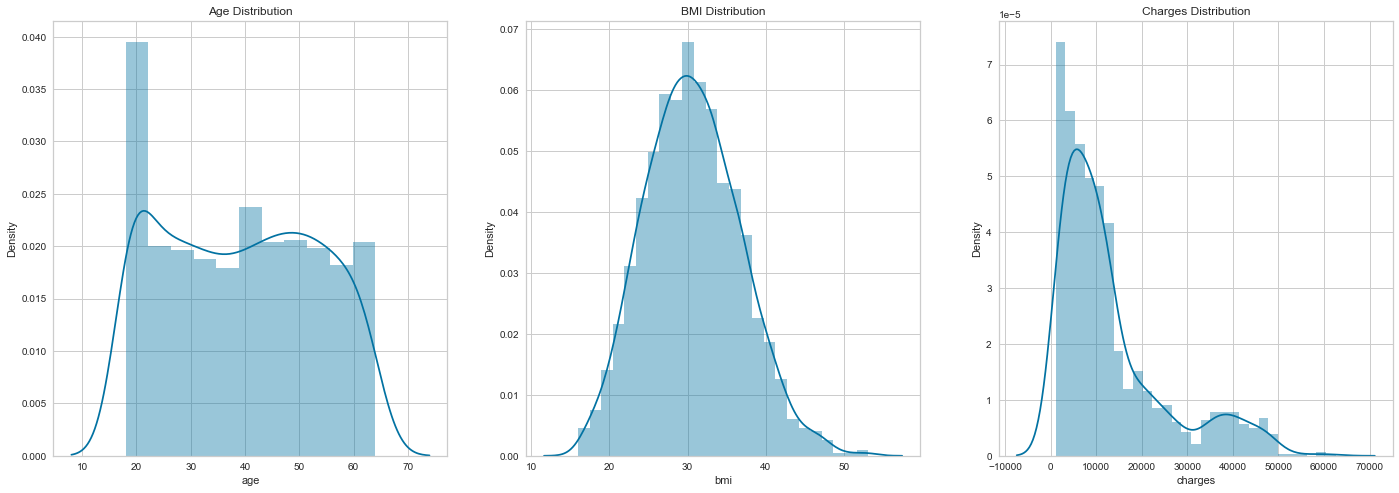

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,8))

sns.distplot(df['age'], ax = ax1)
ax1.title.set_text('Age Distribution')

sns.distplot(df['bmi'], ax = ax2)
ax2.title.set_text('BMI Distribution')

sns.distplot(df['charges'], ax = ax3)
ax3.title.set_text('Charges Distribution')

Kesimpulan dari grafik:
1. Distribusi data pada kolom age tidak normal
2. Distribusi data pada kolom BMI normal dengan kemiringan sedikit ke kanan.
3. Distribusi data pada kolom charges tidak normal, memiliki 2 bukit dan sangat miring ke kanan.

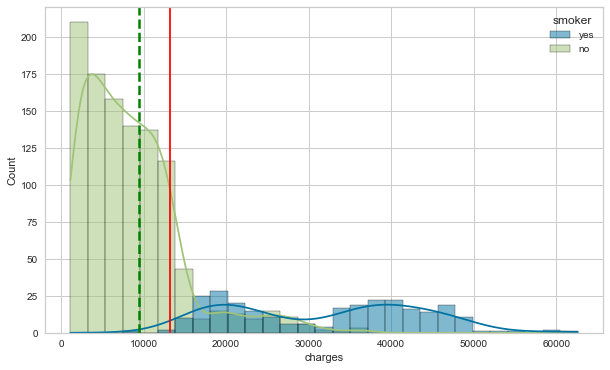

In [14]:
plt.figure(figsize=(10,6))  

sns.histplot(data=df, x="charges", kde=True, hue = 'smoker')    # alur distribusi dari variabel charges. 
plt.axvline(x=df.charges.mean(),color='red')
plt.axvline(x=df.charges.median(),color='green',ls='--',lw=2.5) 

Dari informasi diatas, jelas adanya pengaruh kolom smoker terhadap biaya yang akan dibayar oleh seorang pasien.

### Correlation Test
Pada bagian ini, akan diuji keterkaitan (correlation) antar kolom.


<AxesSubplot:xlabel='bmi', ylabel='charges'>

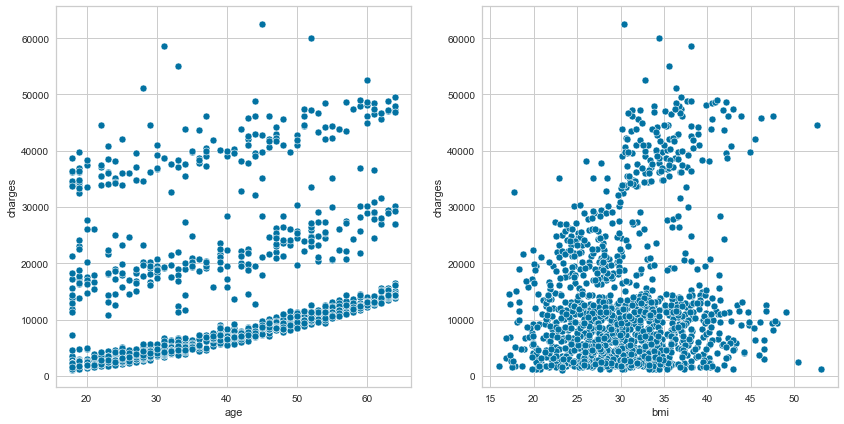

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))

sns.scatterplot(data = df, x = 'age', y = 'charges', ax = ax1)
sns.scatterplot(data = df, x = 'bmi', y = 'charges', ax = ax2)

Dari 2 grafik  tersebut dapat ditarik kesimpulan:
1. Terdapat korelasi positif dengan 3 trend berbeda pada graf age x charges
2. Terdapat sedikit korelasi positif pada graf bmi x charges

Test korelasi kolom objek dengan melakukan label encoding

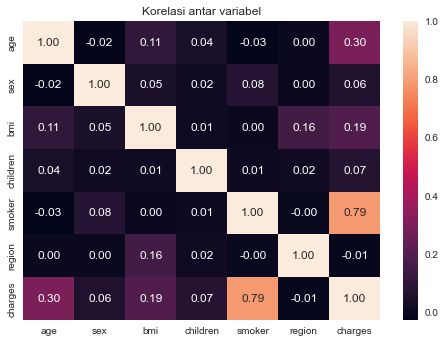

In [16]:
df_corr = df.copy()

objCols = ["sex", "smoker", "region" ]
for objCol in objCols:
    df_corr[objCol] = LabelEncoder().fit_transform(df_corr[objCol])

corr = df_corr.corr()

sns.heatmap(corr,annot=True,fmt=".2f")
plt.title("Korelasi antar variabel")
plt.show()

Dari grafik heatmap tersebut kita dapat melihat bahwa, korelasi antara kolom smoker dengan charges sangat tinggi (positif) dan hal ini selaras dengan pernyataan kami di awal, diikuti dengan kolom age x charges dan bmi x charges.

### Labeling
Di bagian ini, kami akan mengolah data, agar data siap untuk menjadi input pada model kami.

In [17]:
df2 = df.copy() #menghindari adanya ketimpaan data

In [18]:
X = df2.drop(['charges'], axis = 1)
y = df2['charges']

In [19]:
num_pipeline = Pipeline([
    ("Min-Max scaler", MinMaxScaler())
])

cat_pipeline = Pipeline([
    ("One-Hot", OneHotEncoder())
])

In [20]:
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, ["age", "bmi", "children"]),
    ("categorical", cat_pipeline, ["sex", "smoker", "region"])
])

X_prepared = full_pipeline.fit_transform(X)

In [21]:
X_prepared[0]

array([0.02173913, 0.3212268 , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        ])

### Machine Learning

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, random_state = 0, test_size = .3)

In [23]:
linreg = LinearRegression()
bayes = BayesianRidge()
dtr = DecisionTreeRegressor(random_state = 0)
rfr = RandomForestRegressor(random_state = 0)

In [24]:
models = [linreg,dtr,rfr, bayes]
model_name = ["LinearRegression","DecisionTreeRegressor","RandomForestRegressor", "Bayesian Ridge"]

storedData = {
    'rmse' : [],
    'r2' : [],
    'modelName' : []
}

for model, name in zip(models, model_name):
    scores = ['neg_root_mean_squared_error',"r2"]
    cv_score_rmse = cross_val_score(model, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=1), scoring = scores[0])
    cv_score_r2 = cross_val_score(model, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=1), scoring = scores[1])
    storedData['rmse'].append(np.mean(-1 * cv_score_rmse))
    storedData['r2'].append(np.mean(cv_score_r2))
    storedData['modelName'].append(name)
    print("RMSE scores of {} are {}".format(name, -1 * cv_score_rmse))
    print("R2 scores of {}  are {}".format(name, cv_score_r2))
    print("-" * 100)

RMSE scores of LinearRegression are [5533.76085816 5568.91864243 6273.94458984 5630.72391302 7234.65582373]
R2 scores of LinearRegression  are [0.75959491 0.78595268 0.70303036 0.74783509 0.65233747]
----------------------------------------------------------------------------------------------------
RMSE scores of DecisionTreeRegressor are [5794.81567478 6251.60438603 7949.40578656 6798.61119583 7006.19530878]
R2 scores of DecisionTreeRegressor  are [0.7363777  0.73025649 0.52323976 0.63238214 0.67394819]
----------------------------------------------------------------------------------------------------
RMSE scores of RandomForestRegressor are [4137.18663341 4636.38394749 5634.0436481  5165.75440202 5527.42807314]
R2 scores of RandomForestRegressor  are [0.86562666 0.85163658 0.76051897 0.78776173 0.79705968]
----------------------------------------------------------------------------------------------------
RMSE scores of Bayesian Ridge are [5534.66185743 5577.77929491 6263.67414717 

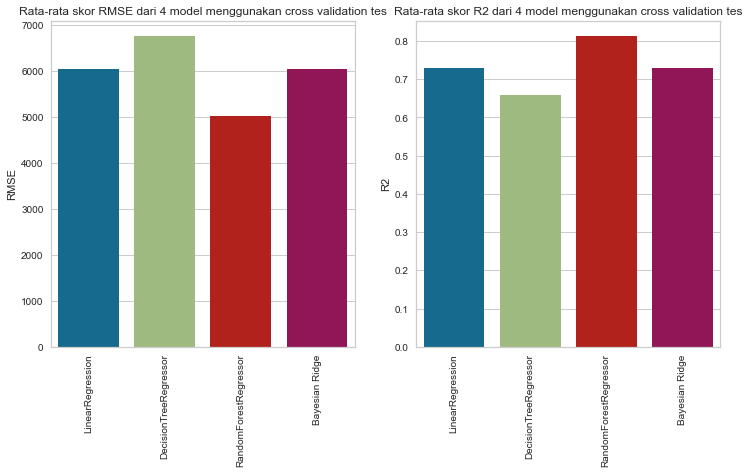

In [25]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,6))

sns.barplot(data = storedData, x = 'modelName', y = 'rmse', ax = ax1)
ax1.title.set_text("Rata-rata skor RMSE dari 4 model menggunakan cross validation tes")
ax1.set_xticklabels(model_name, rotation = 90)
ax1.set_ylabel("RMSE")

sns.barplot(data = storedData, x = 'modelName', y = 'r2', ax = ax2)
ax2.title.set_text("Rata-rata skor R2 dari 4 model menggunakan cross validation tes")
ax2.set_xticklabels(model_name, rotation = 90)
ax2.set_ylabel("R2")
plt.show()

Dapat disimpulkan dari grafik tersebut, bahwa model Random Forest Regressor memiliki nilai RMSE (Root Mean Squared Error) terkecil dan nilai R2 terbesar. Oleh karenanya, model tersebut akan digunakan sebagai main model untuk pengembangan model selanjutnya.

### Hyperparameter Tuning
Pada bagian ini, kami akan melakukan tuning variabel parameter pada model random forest regressor yang akan kami gunakan.

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 20)]
max_features = ['auto', 'log', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
oob_score = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score':oob_score
              }
            

In [27]:
clf = RandomizedSearchCV(rfr, param_distributions = random_grid, cv = KFold(n_splits=5, shuffle=True, random_state=1), scoring = 'neg_root_mean_squared_error')
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'log', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 242, 284, 326,
                                                         368, 410, 452, 494,
                                                         536, 578, 621, 663,
                                                         705, 747, 789, 831,
                                                         873, 915, 957, 1000],
                                        'oob_score': [True]},
                   scoring='neg_root_mean_squ

In [28]:
clf.best_params_

{'oob_score': True,
 'n_estimators': 789,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [29]:
print("Parameter Random Forest Regressor yang Optimal: {}".format(clf.best_params_))
print("Hasil RMSE Terbaik : {}".format(-1 * clf.best_score_))

Parameter Random Forest Regressor yang Optimal: {'oob_score': True, 'n_estimators': 789, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Hasil RMSE Terbaik : 4643.508189533756


In [30]:
opt_model = RandomForestRegressor(
    oob_score = clf.best_params_['oob_score'], 
    n_estimators = clf.best_params_['n_estimators'],
    min_samples_split = clf.best_params_['min_samples_split'],
    min_samples_leaf = clf.best_params_['min_samples_leaf'],
    max_features = clf.best_params_['max_features'],
    max_depth = clf.best_params_['max_depth'],
    bootstrap = clf.best_params_['bootstrap'],
    random_state = 0
)

In [31]:
opt_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=789, oob_score=True, random_state=0)

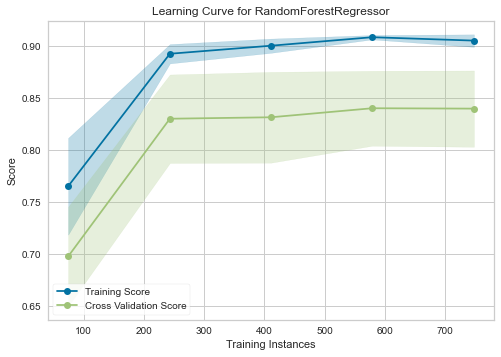

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [32]:
visualizer = LearningCurve(opt_model, scoring='r2', cv = KFold(n_splits=5, shuffle=True, random_state=1))

visualizer.fit(X_train, y_train)    
visualizer.show()   

In [33]:
ypred = opt_model.predict(X_test)

In [34]:
grid_search_rmse = mean_squared_error(y_test,ypred)
print("Nilai RMSE optimum model dari data test adalah {}".format(np.sqrt(grid_search_rmse)))
print("Nilai R2 optimum model dari data test adalah {}".format(r2_score(y_test, ypred)))

Nilai RMSE optimum model dari data test adalah 4752.56708747929
Nilai R2 optimum model dari data test adalah 0.8620728170331743


In [37]:
dummy_x = {
    'age' : [42, 67],
    'sex' : ['male', 'female'],
    'bmi' : [31, 42],
    'children' : [0, 2],
    'smoker' : ['yes', 'no'],
    'region' : ['southeast', 'southeast']
}
dummy_x = pd.DataFrame(dummy_x)

dummy_x_prep = full_pipeline.transform(dummy_x)

In [36]:
dummy_y = opt_model.predict(dummy_x_prep)
dummy_y

array([41687.2858369 , 16968.89780379])